# Analyzing the Michigan State University School Shooting

February 13, 2023 <br>
8:18 p.m. – 11:35 p.m (EST)

"From Feb. 13 to Feb. 14, between the hours of 8 p.m. and 1 a.m., Ingham County 911 received 2,100 phone calls, with 1,450 being 911 calls. This is the equivalent of 2 ½ days’ worth of calls for the dispatch center, all within a five-hour period, police said."
https://www.fox2detroit.com/news/view-police-release-full-michigan-state-university-shooting-timeline-shooters-note

In [279]:
import numpy as np
import pandas as pd
import os
import folium
from folium.plugins import FastMarkerCluster
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from datetime import timedelta
import re
import pytz
import seaborn as sns

# Set Seaborn as the default style
sns.set()
sns.set_style("whitegrid")

## for geo fencing
from shapely.geometry import Point, Polygon

## Importing Data

In this part of the notebook, we will import data from East Lansing Michigan which has been cleaned to fit in relevant events for michigan state university.

In [280]:
data = pd.read_csv('../data/msu_only_clustered.csv').drop(columns=['Unnamed: 0'])

In [281]:
data.head()

,lat,lon,key,DATETIME,cluster,centroids
0,42.732149,-84.476666,6165114603,2021-01-01 07:10:53.342000+00:00,819,0
1,42.732149,-84.476666,6165114603,2021-01-01 07:10:53.351000+00:00,819,0
2,42.732149,-84.476666,6165114603,2021-01-01 07:10:53.342000+00:00,819,0
3,42.732149,-84.476666,6165114603,2021-01-01 07:10:53.434000+00:00,819,0
4,42.724661,-84.491644,6165114597,2021-01-01 15:08:11.855000+00:00,2451,0


Next, let's create a geofence around Michigan State University.

In [282]:
# Define the boundary coordinates for Michigan State University

# Define the coordinates for the polygon
point0 = (-84.493956,42.729137)
point1 = (-84.493561,42.733422)
point2 = (-(84 + 29/60 + 7/3600), 42 + 44/60 + 7/3600)
point3 = (-(84 + 27/60 + 44/3600), 42 + 43/60 + 44/3600)
point4 = (-(84 + 27/60 + 43/3600), 42 + 41/60 + 50/3600)
point5 = (-(84 + 30/60 + 10/3600), 42 + 41/60 + 50/3600)
point6 = (-(84 + 30/60 + 20/3600), 42 + 42/60 + 11/3600)
point7 = (-(84 + 30/60 + 15/3600), 42 + 43/60 + 8/3600)

# Define the boundary coordinates for the polygon
msu_coordinates = [ point1,point2, point3, point4, point5, point6, point7]

# Create a polygon using the boundary coordinates
msu_polygon = Polygon(msu_coordinates)

# Example location point to check
location_point = Point(-84.471264, 42.718732)

# Check if the location point is within the MSU geofence
is_within_msu = msu_polygon.contains(location_point)

# Print the result
if is_within_msu:
    print("The location point is within Michigan State University.")
else:
    print("The location point is outside Michigan State University.")

The location point is within Michigan State University.


In [283]:
# Create a polygon using the boundary coordinates
msu_polygon = Polygon(msu_coordinates)

# Create a Folium map centered around MSU coordinates
msu_map = folium.Map(location=[42.724661, -84.471515], zoom_start=16)

# Convert the MSU polygon to GeoJSON format
msu_geojson = folium.GeoJson(msu_polygon.__geo_interface__)

# Add the GeoJSON polygon to the map
msu_geojson.add_to(msu_map)

# Display the map
msu_map

In [284]:

# Assuming 'data' is your DataFrame
data_sorted = data.sort_values(by='DATETIME').reset_index(drop=True)

# Define a function to handle the conversion of datetime strings
def datetime_parser(x):
    pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})")
    match = pattern.match(x)
    if match:
        return pd.to_datetime(match.group(), format='%Y-%m-%d %H:%M:%S')
    else:
        return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z')

data_sorted['DATETIME'] = data_sorted['DATETIME'].apply(datetime_parser)
data_sorted

,lat,lon,key,DATETIME,cluster,centroids
0,42.732149,-84.476666,6165114603,2021-01-01 07:10:53,819,0
1,42.732149,-84.476666,6165114603,2021-01-01 07:10:53,819,0
2,42.732149,-84.476666,6165114603,2021-01-01 07:10:53,819,0
3,42.732149,-84.476666,6165114603,2021-01-01 07:10:53,819,0
4,42.724661,-84.491644,6165114597,2021-01-01 15:08:11,2451,0
...,...,...,...,...,...,...
61270,42.716399,-84.482439,6165114615,2023-05-31 17:38:33,884,0
61271,42.716399,-84.482439,6165114615,2023-05-31 17:38:34,884,0
61272,42.700242,-84.500721,6162115888,2023-05-31 17:48:53,1803,0
61273,42.700242,-84.500721,6162115888,2023-05-31 17:48:53,1803,0


Now that our data is sorted and clean, let's deploy our initial model on it. Currently, our model breaks down the events into 15 minute intervals and calculates the total number of calls being made from MSU in that 15 minute interval, which is then stored in a distribution array which we can then refer too for calculating the p-value of the number of calls happening at any point.

In [308]:
start_time = data_sorted.iloc[0].DATETIME
end_time = start_time + timedelta(minutes=30)
total_time = data_sorted.DATETIME.iloc[-1] - start_time
iters = int(total_time.total_seconds() // 900)
dist = []

while start_time < data_sorted.DATETIME.iloc[-1]:
    all_data = data_sorted[(data_sorted.DATETIME >= start_time) & (data_sorted.DATETIME < end_time)]
    if all_data.shape[0] == 0:
        dist.append(0)
        start_time = start_time + timedelta(minutes=15)
        end_time = end_time + timedelta(minutes=15)
        continue
    all_data = all_data.groupby("key").max()
    dist.append(len(all_data)) 
    start_time = start_time + timedelta(minutes=15)
    end_time = end_time + timedelta(minutes=15)
dist = np.array(dist)

We will plot a Line Plot and calculate quick summary statistics to check the distribution of the call numbers from MSU.

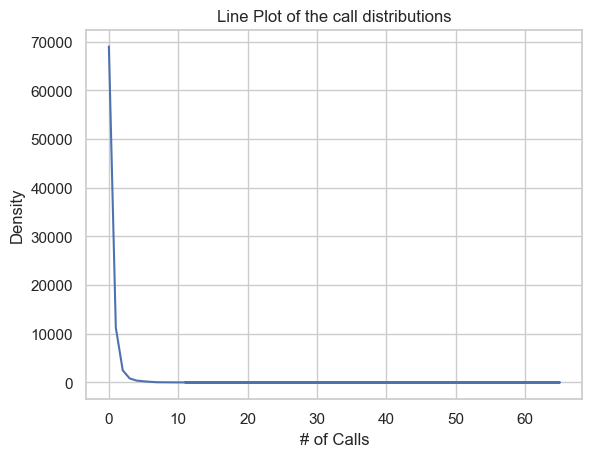

In [309]:
plt.plot(pd.Series(dist).value_counts())
plt.title('Line Plot of the call distributions')
plt.ylabel('Density')
plt.xlabel('# of Calls')
plt.show()

In [310]:
pd.Series(dist).describe()

count    84526.000000
mean         0.285427
std          1.029283
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         65.000000
dtype: float64

We can see that the max calls were round 65 calls within 30 minutes (with 15 minute overlaps)! Next, we will calculate p-value for every 30 minute intervals. This test helps assess whether the observed counts deviate significantly from what would be expected under a null hypothesis.

The p-value is a measure that indicates the probability of obtaining results as extreme as the observed counts, assuming the null hypothesis is true. In this case, the null hypothesis might be that the call counts follow a certain expected distribution or that there is no significant change in call frequency over time.

The p-value is calculated based on the test statistic and the chosen statistical distribution. It represents the probability of observing results as extreme as the ones obtained, assuming the null hypothesis is true. A small p-value suggests that the observed data is unlikely under the null hypothesis, leading to the rejection of the null hypothesis in favor of an alternative hypothesis.

By computing the p-value for each 30-minute interval, you can identify specific time periods where the call counts deviate significantly from the expected pattern, thereby providing valuable insights into the underlying dynamics of the call data. This analysis can help uncover patterns, trends, or anomalies that may not be apparent from a simple examination of the raw call counts.

In [311]:
def findp_val(dist,val):
    return np.mean(val <= np.array(dist))

In [312]:
start_time = data_sorted.iloc[0].DATETIME
end_time = start_time + timedelta(minutes=30)
total_time = data_sorted.DATETIME.iloc[-1] - start_time
iters = int(total_time.total_seconds() // 900)
events = []

while start_time < data_sorted.DATETIME.iloc[-1]:
    all_data = data_sorted[(data_sorted.DATETIME >= start_time) & (data_sorted.DATETIME < end_time)]
    if all_data.shape[0] == 0:
        start_time = start_time + timedelta(minutes=15)
        end_time = end_time + timedelta(minutes=15)
        continue
    all_data = all_data.groupby("key").max()
    p_value = findp_val(dist,len(all_data))
    if p_value < 0.005:
        events.append(
        {
            'p_value':p_value,
            'cluster': index,
            'start_time':start_time,
            'end_time':end_time
        })
    start_time = start_time + timedelta(minutes=15)
    end_time = end_time + timedelta(minutes=15)

In [313]:
events = pd.DataFrame(events)

In [314]:
events.sort_values('p_value')

,p_value,cluster,start_time,end_time
235,0.000012,1594,2023-02-14 03:40:53,2023-02-14 04:10:53
236,0.000024,1594,2023-02-14 03:55:53,2023-02-14 04:25:53
234,0.000059,1594,2023-02-14 03:25:53,2023-02-14 03:55:53
237,0.000059,1594,2023-02-14 04:10:53,2023-02-14 04:40:53
241,0.000059,1594,2023-02-14 05:10:53,2023-02-14 05:40:53
...,...,...,...,...
136,0.003206,1594,2022-09-02 19:55:53,2022-09-02 20:25:53
138,0.003206,1594,2022-09-02 20:25:53,2022-09-02 20:55:53
144,0.003206,1594,2022-09-02 21:55:53,2022-09-02 22:25:53
121,0.003206,1594,2022-05-19 13:55:53,2022-05-19 14:25:53


Finding the events with the lowest p_values, we can find events (30 minute interval periods) where the 911 calls were deviated the most from the overall distribution. Additionally, we change the start time for the events from UTC to EST (the server stores the event time in UTC) to make easy comparisons to the actual times of the events. 

In [315]:
events['start_time'] = events['start_time'].dt.tz_localize('UTC')
events['start_time'] = events['start_time'].dt.tz_convert(pytz.timezone('EST'))

In [316]:
events['end_time'] = events['end_time'].dt.tz_localize('UTC')
events['end_time'] = events['end_time'].dt.tz_convert(pytz.timezone('EST'))

In [317]:
events.sort_values('p_value')

,p_value,cluster,start_time,end_time
235,0.000012,1594,2023-02-13 22:40:53-05:00,2023-02-13 23:10:53-05:00
236,0.000024,1594,2023-02-13 22:55:53-05:00,2023-02-13 23:25:53-05:00
234,0.000059,1594,2023-02-13 22:25:53-05:00,2023-02-13 22:55:53-05:00
237,0.000059,1594,2023-02-13 23:10:53-05:00,2023-02-13 23:40:53-05:00
241,0.000059,1594,2023-02-14 00:10:53-05:00,2023-02-14 00:40:53-05:00
...,...,...,...,...
136,0.003206,1594,2022-09-02 14:55:53-05:00,2022-09-02 15:25:53-05:00
138,0.003206,1594,2022-09-02 15:25:53-05:00,2022-09-02 15:55:53-05:00
144,0.003206,1594,2022-09-02 16:55:53-05:00,2022-09-02 17:25:53-05:00
121,0.003206,1594,2022-05-19 08:55:53-05:00,2022-05-19 09:25:53-05:00


## Outlier Analysis for the events picked up by our model

In [318]:
sorted_events = events.sort_values('p_value')

In [319]:
sorted_events['date'] = sorted_events['start_time'].apply(lambda x: x.date())

In [320]:
sorted_events_date_wise = sorted_events.groupby('date').count()[['cluster']]
sorted_events_date_wise = sorted_events_date_wise.reset_index()

In [321]:
sorted_events_date_wise

,date,cluster
0,2021-03-18,1
1,2021-05-16,1
2,2021-06-10,1
3,2021-07-05,2
4,2021-07-06,1
...,...,...
89,2023-04-18,2
90,2023-04-23,1
91,2023-04-30,2
92,2023-05-14,1


### Overall 2-year distribution for East Lansing, MI

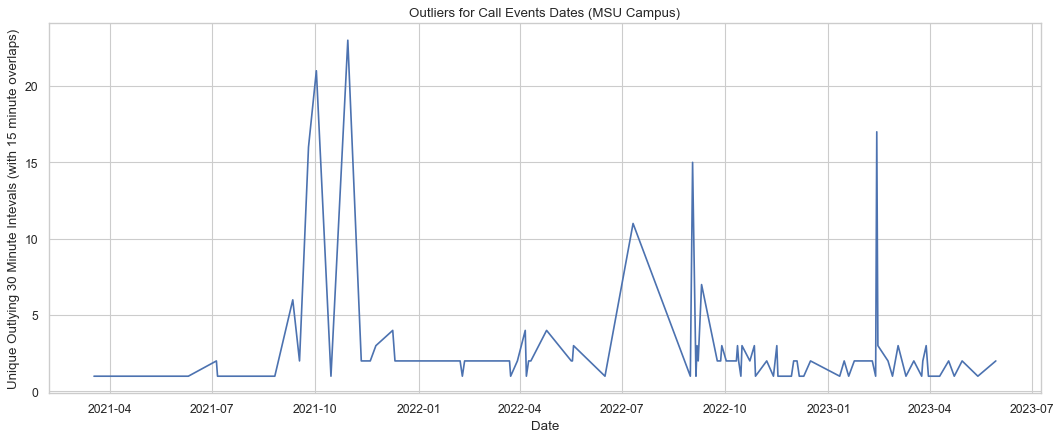

In [322]:
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(sorted_events_date_wise['date'],sorted_events_date_wise['cluster'])
plt.title('Outliers for Call Events Dates (MSU Campus)')
plt.ylabel('Unique Outlying 30 Minute Intevals (with 15 minute overlaps)')
plt.xlabel('Date')
plt.show()

1. 2021-09-11 could either be a game or this event https://www.wilx.com/2021/09/11/one-dead-two-critical-condition-following-two-car-crash/
2. 2021-09-25 had a game between Nebranska Cornhuskers & MSU
3. 2021-10-02 had a game between MSU and Western Kentucky
4. 2022-10-30 had a big game and a lot of different events like https://eastlansinginfo.news/young-people-in-spartan-garb-set-fires-commit-destruction-after-msu-beats-um/ and https://statenews.com/article/2021/10/vehicle-flipped-multiple-fires-in-cedar-village-after-msu-football-win

5. One of the dates is 2022-09-02 which might either be a game that happened or https://police.msu.edu/2022/09/02/alert-issued-at-09-02-2022-105455-pm-edt/


### Checking our models performance on MSU Data

In [323]:
# Specify the date
date_str = "2023-02-13"

# Convert the date string to a datetime object
date = datetime.strptime(date_str, "%Y-%m-%d")

# Get the start datetime
start_datetime = datetime(date.year, date.month, date.day, 0, 0, 0)

# Get the end datetime
end_datetime = datetime(date.year, date.month, date.day+1, 20, 59, 59)

# Convert to datetime64[ns, UTC]
start_datetime_utc = pd.to_datetime(start_datetime).tz_localize('UTC')
end_datetime_utc = pd.to_datetime(end_datetime).tz_localize('UTC')

start_datetime_utc = start_datetime_utc.to_pydatetime().date()
end_datetime_utc = end_datetime_utc.to_pydatetime().date()

print("Start datetime (UTC):", start_datetime_utc)
print("End datetime (UTC):", end_datetime_utc)

Start datetime (UTC): 2023-02-13
End datetime (UTC): 2023-02-14


In [347]:
sorted_by_date = data.sort_values(by='DATETIME').reset_index(drop=True)
sorted_by_date = sorted_by_date.assign(DATETIME=sorted_by_date['DATETIME'].apply(datetime_parser))
results = sorted_by_date[(sorted_by_date['DATETIME'].dt.date >= start_datetime_utc) & (sorted_by_date['DATETIME'].dt.date <= end_datetime_utc)]

In [348]:
results.head()

,lat,lon,key,DATETIME,cluster,centroids
53534,42.723631,-84.463320,6165115836,2023-02-13 06:16:04,1677,0
53535,42.723631,-84.463320,6165115836,2023-02-13 06:16:04,1677,0
53536,42.723631,-84.463320,6165115836,2023-02-13 06:16:04,1677,0
53537,42.733630,-84.486837,6165113715,2023-02-13 13:01:49,500,0
53538,42.733630,-84.486837,6165113715,2023-02-13 13:01:49,500,0


In [349]:
results['DATETIME'] =  results['DATETIME'].dt.tz_localize('UTC')

/var/folders/4q/pymtr0qd38d5nlrw_myxq5r00000gn/T/ipykernel_92647/3612519018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['DATETIME'] =  results['DATETIME'].dt.tz_localize('UTC')


In [350]:
results['DATETIME_EST'] = results['DATETIME'].dt.tz_convert('EST')

/var/folders/4q/pymtr0qd38d5nlrw_myxq5r00000gn/T/ipykernel_92647/2507896671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['DATETIME_EST'] = results['DATETIME'].dt.tz_convert('EST')


In [351]:
results['DATETIME']

53534   2023-02-13 06:16:04+00:00
53535   2023-02-13 06:16:04+00:00
53536   2023-02-13 06:16:04+00:00
53537   2023-02-13 13:01:49+00:00
53538   2023-02-13 13:01:49+00:00
                   ...           
55641   2023-02-14 23:54:45+00:00
55642   2023-02-14 23:55:00+00:00
55643   2023-02-14 23:55:00+00:00
55644   2023-02-14 23:55:00+00:00
55645   2023-02-14 23:55:00+00:00
Name: DATETIME, Length: 2112, dtype: datetime64[ns, UTC]

In [352]:
results.head()

,lat,lon,key,DATETIME,cluster,centroids,DATETIME_EST
53534,42.723631,-84.463320,6165115836,2023-02-13 06:16:04+00:00,1677,0,2023-02-13 01:16:04-05:00
53535,42.723631,-84.463320,6165115836,2023-02-13 06:16:04+00:00,1677,0,2023-02-13 01:16:04-05:00
53536,42.723631,-84.463320,6165115836,2023-02-13 06:16:04+00:00,1677,0,2023-02-13 01:16:04-05:00
53537,42.733630,-84.486837,6165113715,2023-02-13 13:01:49+00:00,500,0,2023-02-13 08:01:49-05:00
53538,42.733630,-84.486837,6165113715,2023-02-13 13:01:49+00:00,500,0,2023-02-13 08:01:49-05:00


13th & 14th Feb, 2023 outliers

In [353]:
start_time = results.iloc[0].DATETIME
end_time = start_time + timedelta(minutes=30)
total_time = results.DATETIME.iloc[-1] - start_time
iters = int(total_time.total_seconds() // 900)
events = []

while start_time < results.DATETIME.iloc[-1]:
    all_data = results[(results.DATETIME >= start_time) & (results.DATETIME < end_time)]
    if all_data.shape[0] == 0:
        start_time = start_time + timedelta(minutes=15)
        end_time = end_time + timedelta(minutes=15)
        continue
    all_data = all_data.groupby("key").max()
    p_value = findp_val(dist,len(all_data))
    events.append(
        {
            'p_value':p_value,
            'start_time':start_time,
            'end_time':end_time,
            'count':len(all_data)
    })
    start_time = start_time + timedelta(minutes=15)
    end_time = end_time + timedelta(minutes=15)

In [354]:
sorted_events = pd.DataFrame(events).sort_values('p_value')
sorted_events['start_time'] = sorted_events['start_time'].dt.tz_convert(pytz.timezone('EST'))
sorted_events['end_time'] = sorted_events['end_time'].dt.tz_convert(pytz.timezone('EST'))
sorted_events.head()

,p_value,start_time,end_time,count
16,0.000012,2023-02-13 22:46:04-05:00,2023-02-13 23:16:04-05:00,64
15,0.000024,2023-02-13 22:31:04-05:00,2023-02-13 23:01:04-05:00,63
21,0.000059,2023-02-14 00:01:04-05:00,2023-02-14 00:31:04-05:00,59
18,0.000059,2023-02-13 23:16:04-05:00,2023-02-13 23:46:04-05:00,57
17,0.000059,2023-02-13 23:01:04-05:00,2023-02-13 23:31:04-05:00,58


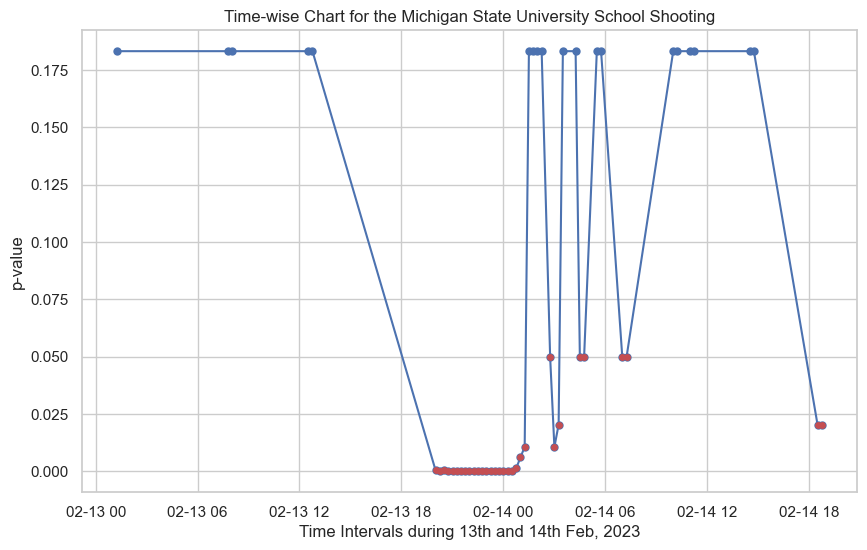

In [355]:
# Assuming you have time_intervals and p_values as lists or arrays
time_data = pd.DataFrame(events)
time_intervals = time_data['start_time'].dt.tz_convert(pytz.timezone('EST')) # List of time intervals
p_values = time_data['p_value'] # List of p-values

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the p-values over time intervals
ax.plot(time_intervals, p_values, marker='o', linestyle='-', color='b',mew=0)

# Highlight lower p-values
threshold = 0.05  # Set your threshold for highlighting p-values
highlight_indices = np.where(np.array(p_values) < threshold)[0]

# Highlight the lower p-values
for i in highlight_indices:
    ax.plot(time_intervals[i], p_values[i], marker='o', markersize=5, linestyle='', color='r', mew=0,mec='red')

# Set labels and title
ax.set_xlabel('Time Intervals during 13th and 14th Feb, 2023')
ax.set_ylabel('p-value')
ax.set_title('Time-wise Chart for the Michigan State University School Shooting')

# Show the plot
plt.show()

In [356]:
start = pd.to_datetime('7pm 13th Feb, 2023').tz_localize('EST')

In [357]:
end = pd.to_datetime('2am 14th Feb, 2023').tz_localize('EST')

In [358]:
relevant_events = pd.DataFrame(events)
relevant_events['start_time'] = relevant_events['start_time'].dt.tz_convert(pytz.timezone('EST'))
relevant_events['end_time'] = relevant_events['end_time'].dt.tz_convert(pytz.timezone('EST'))

In [359]:
relevant_events[(relevant_events['start_time'] >= start) & (relevant_events['start_time'] <= end)]

,p_value,start_time,end_time,count
5,0.000426,2023-02-13 20:01:04-05:00,2023-02-13 20:31:04-05:00,11
6,0.000201,2023-02-13 20:16:04-05:00,2023-02-13 20:46:04-05:00,17
7,0.000568,2023-02-13 20:31:04-05:00,2023-02-13 21:01:04-05:00,10
8,0.000201,2023-02-13 20:46:04-05:00,2023-02-13 21:16:04-05:00,19
9,0.000166,2023-02-13 21:01:04-05:00,2023-02-13 21:31:04-05:00,28
10,0.000142,2023-02-13 21:16:04-05:00,2023-02-13 21:46:04-05:00,39
11,0.000118,2023-02-13 21:31:04-05:00,2023-02-13 22:01:04-05:00,50
12,0.000059,2023-02-13 21:46:04-05:00,2023-02-13 22:16:04-05:00,57
13,0.000071,2023-02-13 22:01:04-05:00,2023-02-13 22:31:04-05:00,56
14,0.000059,2023-02-13 22:16:04-05:00,2023-02-13 22:46:04-05:00,58


The observation you made regarding the outlier at around 8 pm on February 13th, 2023, where 11 calls were identified within the 8:00 pm to 8:30 pm time interval with a p-value of 0.000426, suggests that there was a significant deviation from the expected call frequency during that specific time period.

A low p-value indicates that the probability of obtaining results as extreme as the observed ones, under the assumption that there is no significant change in call frequency, is very low. In this case, the p-value of 0.000426 indicates that the likelihood of observing 11 calls within that 30-minute interval purely by chance, assuming the expected call frequency is constant, is less than 0.05%.